<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/documentation/assets/SG_img/SG%20-%20Horizontal%20Glow%202.png'>

## 👋🏽 What's up! Welcome to the tutorial, where you'll learn how to use [SuperGradients](https://github.com/Deci-AI/super-gradients) with the YOLO-NAS-Pose model from [Deci AI](https://deci.ai/).


I'll be guiding you through this notebook. At any point, if you get stuck or have questions, there are three ways to get in touch:

1) Send me an email with your issue: harpreet.sahota@deci.ai

2) Hop into the [Deep Learning Daily (powered by Deci) Discord server](https://discord.gg/p9ecgRhDR8), and let me know what your question is.

3) [Open an issue on GitHub](https://github.com/Deci-AI/super-gradients/issues/new/choose)

Cheers,

[Harpreet](https://twitter.com/DataScienceHarp)


In [1]:
%%capture
!pip install super-gradients
!pip install -U git+https://github.com/ytdl-org/youtube-dl.git

In [ ]:
import torch
import os
import pathlib
import re
from imutils import paths
from IPython.display import YouTubeVideo

In [4]:
# @title Downloading some images of people posing
def download_and_rename(urls):
    """
    Download files from the given URLs and rename them using a specific convention,
    while preserving the original file extension.

    Args:
    - urls (list of str): List of URLs to download.

    Returns:
    - list of str: List of filenames after renaming.
    """
    renamed_files = []
    for index, url in enumerate(urls, start=1):
        # Download the file using wget without specifying a filename
        os.system(f"wget {url}")

        # Get the original filename from the URL
        original_filename = url.split("/")[-1]

        # Get the file extension of the downloaded file
        file_extension = pathlib.Path(original_filename).suffix

        # Rename the downloaded file with the desired name while preserving the file extension
        new_name = f"pose{index}{file_extension}"
        os.rename(original_filename, new_name)
        renamed_files.append(new_name)

    return renamed_files


urls = [
    "https://mir-s3-cdn-cf.behance.net/project_modules/max_3840/2712bd29493563.55f6ec5e98924.jpg",
    "https://i.pinimg.com/736x/5a/8a/5c/5a8a5c4cd658580ae4719e5c96043541.jpg",
    "https://mir-s3-cdn-cf.behance.net/project_modules/max_1200/4d222729493563.55f6420cd3768.jpg"

]
downloaded_files = download_and_rename(urls)

people_posing = list(paths.list_images("."))

--2024-02-12 11:47:28--  https://mir-s3-cdn-cf.behance.net/project_modules/max_3840/2712bd29493563.55f6ec5e98924.jpg
Resolving mir-s3-cdn-cf.behance.net (mir-s3-cdn-cf.behance.net)... 18.165.140.86, 18.165.140.75, 18.165.140.26, ...
Connecting to mir-s3-cdn-cf.behance.net (mir-s3-cdn-cf.behance.net)|18.165.140.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2774274 (2.6M) [image/jpg]
Saving to: ‘2712bd29493563.55f6ec5e98924.jpg’

     0K .......... .......... .......... .......... ..........  1%  580K 5s
    50K .......... .......... .......... .......... ..........  3%  501K 5s
   100K .......... .......... .......... .......... ..........  5%  623K 5s
   150K .......... .......... .......... .......... ..........  7% 1.57M 4s
   200K .......... .......... .......... .......... ..........  9% 1.47M 3s
   250K .......... .......... .......... .......... .......... 11% 2.43M 3s
   300K .......... .......... .......... .......... .......... 12%  109K 5s
   35

# Instantiate the model!

Start by instantiating a pretrained model. YOLO-NAS-Pose comes in three flavors: `yolo_nas_pose_s`, `yolo_nas_pose_m`, and `yolo_nas_pose_l`.

You'll use `yolo_nas_pose_l` throughout this notebook. Because you should always go big, or go home.

It's a good life philosophy.

**Note:** I am using a High-RAM instance of a T4 when running this notebook. If you don't have access to the High-RAM instance, I suggest trying the medium or small versions of the model. If you think you have enough RAM, but find this taking too much memory for your liking, set `fuse_model=False` in the `predict` method.

In [6]:
!pip install super_gradients

  Using cached super_gradients-3.6.0-py3-none-any.whl.metadata (40 kB)
  Using cached boto3-1.34.39-py3-none-any.whl.metadata (6.6 kB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl.metadata (5.4 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached coverage-5.3.1-py3-none-any.whl
  Using cached Sphinx-4.0.3-py3-none-any.whl (2.9 MB)
  Using cached sphinx_rtd_theme-2.0.0-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached torchmetrics-0.8.0-py3-none-any.whl (408 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl (154 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
INFO: pip is looking at multiple versions of super-gradients to determine which version is compatible with other requirements. This could take a while.
  Using cached super_gradients-3.5.0-py3-none-any.whl.metadata (39 kB)
  Using cached super_gradients-3.4.1-py3-none-any.whl.metadata (37 kB)
  Using cached super_gradients-3.4.0-py3-none-any.whl.metadata (37 kB)
  Using

In [5]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

yolo_nas_pose = models.get("yolo_nas_pose_l", pretrained_weights="coco_pose").cuda()

ModuleNotFoundError: No module named 'super_gradients'

## 🖼️  Predicting is a one-liner: `yolo_nas_pose.to(device).predict(input_file)`

Once the model has been instantiated all you have to do is call the `predict` method. The `predict()` method is built to handle multiple data formats and types.

Here is the full list of what `predict()` method can handle:

| Argument Semantics                 | Argument Type      | Supported layout                  | Example                                                                                        | Notes                                                                                            |
|------------------------------------|--------------------|-----------------------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| Path to local image                | `str`              | -                                 | `predict("path/to/image.jpg")`                                                                 | All common image extensions are supported.                                                       |
| Path to images directory           | `str`              | -                                 | `predict("path/to/images/directory")`                                                          |                                                                                                  |
| Path to local video                | `str`              | -                                 | `predict("path/to/video.mp4")`                                                                 | All common video extensions are supported.                                                       |
| URL to remote image                | `str`              | -                                 | `predict("https://example.com/image.jpg")`                                                     |                                                                                                  |
| 3-dimensional Numpy image          | `np.ndarray`       | `[H, W, C]`                       | `predict(np.zeros((480, 640, 3), dtype=np.uint8))`                                             | Channels last, RGB channel order for 3-channel images                                            |
| 4-dimensional Numpy image          | `np.ndarray`       | `[N, H, W, C]` or `[N, C, H, W]`  | `predict(np.zeros((480, 640, 3), dtype=np.uint8))`                                             | Tensor layout (NHWC or NCHW) is inferred w.r.t to number of input channels of underlying model   |
| List of 3-dimensional numpy arrays | `List[np.ndarray]` | `[H1, W1, C]`, `[H2, W2, C]`, ... | `predict([np.zeros((480, 640, 3), dtype=np.uint8), np.zeros((384, 512, 3), dtype=np.uint8) ])` | Images may vary in size, but should have same number of channels                                 |
| 3-dimensional Torch Tensor         | `torch.Tensor`     | `[H, W, C]` or `[C, H, W]`        | `predict(torch.zeros((480, 640, 3), dtype=torch.uint8))`                                       | Tensor layout (HWC or CHW) is inferred w.r.t to number of input channels of underlying model     |
| 4-dimensional Torch Tensor         | `torch.Tensor`     | `[N, H, W, C]` or `[N, C, H, W]`  | `predict(torch.zeros((4, 480, 640, 3), dtype=torch.uint8))`                                    | Tensor layout (NHWC or NCHW) is inferred w.r.t to number of input channels of underlying model   |

**Important note** - When using batched input (4-dimensional `np.ndarray` or `torch.Tensor`) formats, **normalization and size preprocessing will be applied to these inputs**.




### For more details about predicting using YOLO-NAS-Pose, check out the [docs](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ModelPredictions.md)

### Let's wrap the predict method in a function just for this notebook. But really it's just one line to predict! And this is it: `yolo_nas_pose.to(device).predict(input_file)`

In [5]:
# @title Run this cell for prediction function
def make_prediction(input_file, action, confidence=0.55):
    """
    Make a prediction using the fixed model and device, and either show or save the result.

    Args:
    - input_file (str): Path to the input file.
    - action (str): Either 'show' or 'save'.
    - confidence (float, optional): Confidence threshold. Defaults to 0.75.

    Returns:
    - None

    Raises:
    - ValueError: If the action is not 'show' or 'save'.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if action == "show":
        yolo_nas_pose.to(device).predict(input_file, conf=confidence).show()
    elif action == "save":
        output_file = pathlib.Path(input_file).stem + "-detections" + pathlib.Path(input_file).suffix
        yolo_nas_pose.to(device).predict(input_file, conf=confidence).save(output_file)
        print(f"Prediction saved to {output_file}")
    else:
        raise ValueError("Action must be either 'show' or 'save'.")

# 📸 Inference on images

[2024-02-12 06:13:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


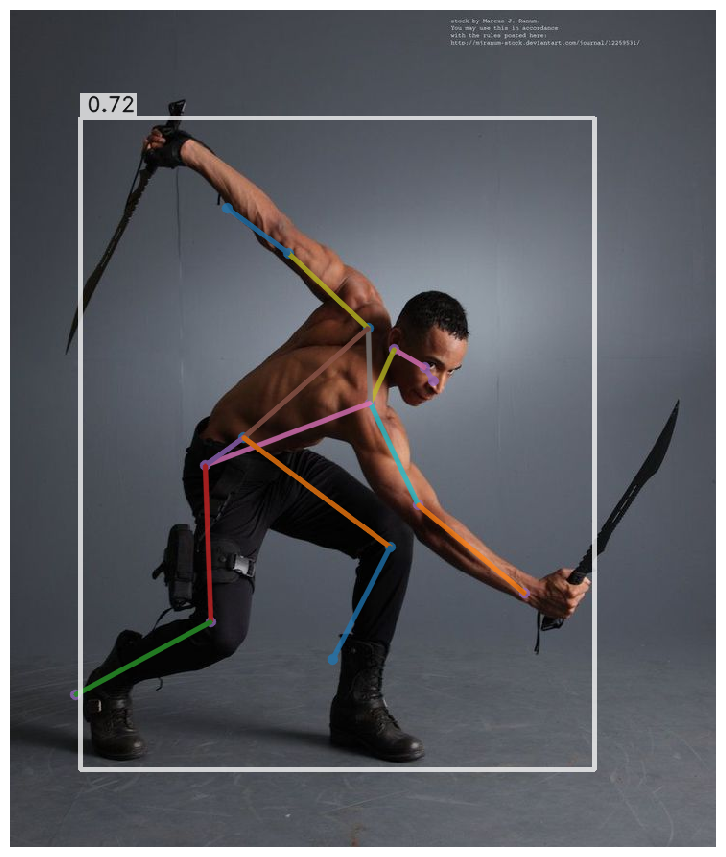

In [6]:
make_prediction(people_posing[0], "show")

[2023-11-06 16:49:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


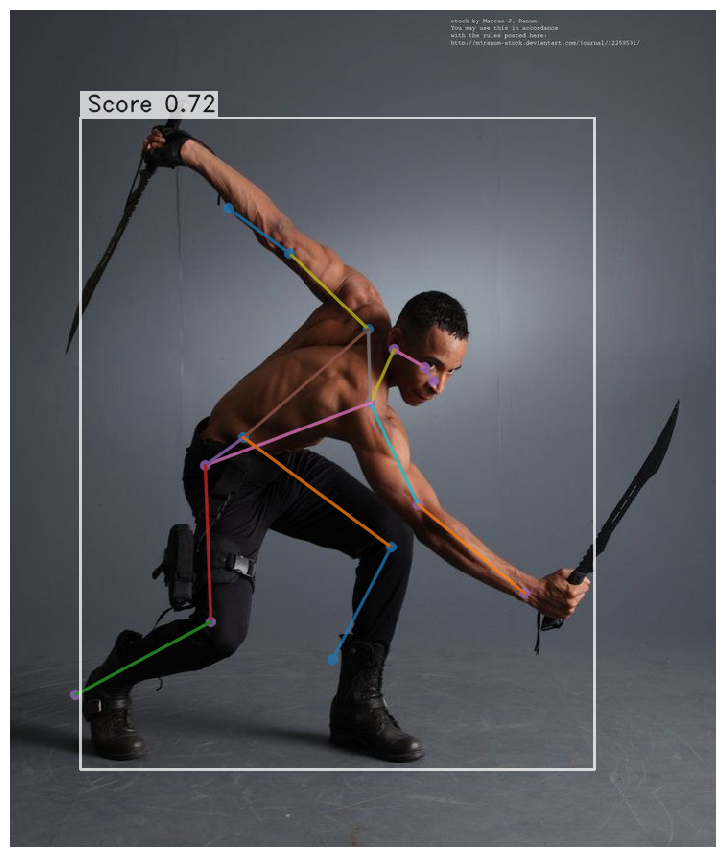

In [ ]:
make_prediction(people_posing[1], "show")

[2024-02-12 06:13:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


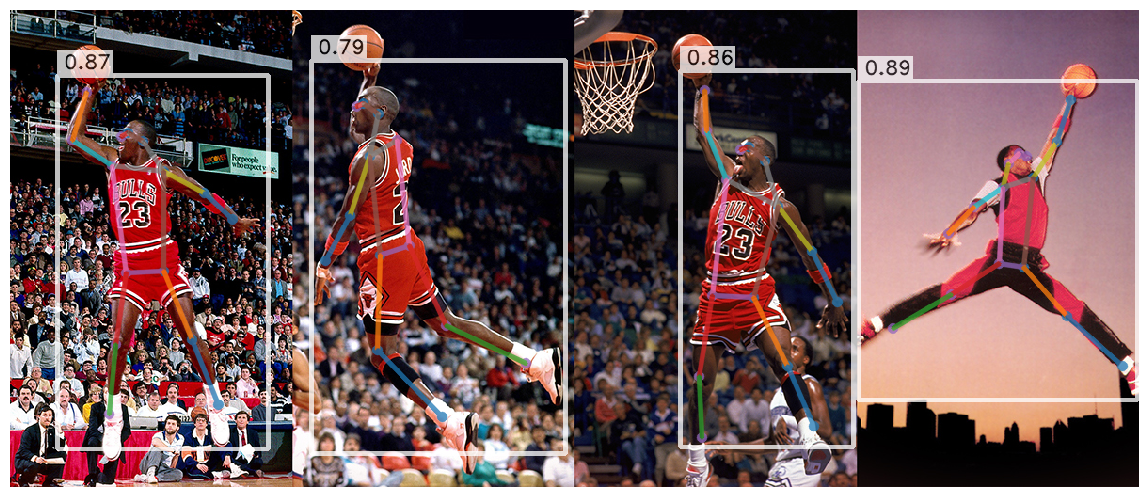

In [7]:
make_prediction(people_posing[2], "show")

# 🌐 Predict using a URL

[2024-02-12 06:13:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


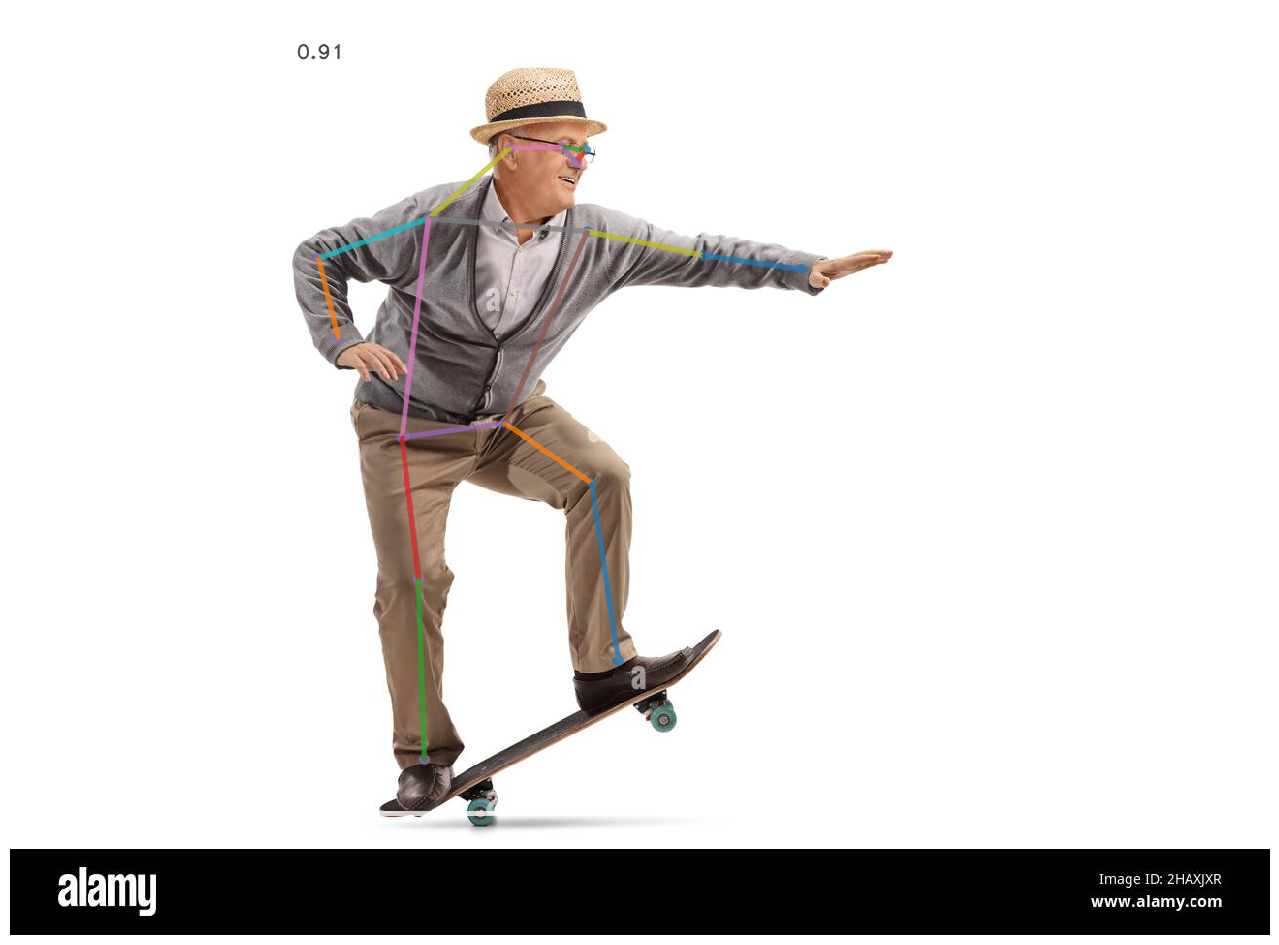

In [8]:
url = "https://c8.alamy.com/comp/2HAXJXR/full-length-profile-shot-of-an-elderly-man-performing-a-trick-on-a-skateboard-isolated-on-white-background-2HAXJXR.jpg"

make_prediction(url, "show")

[2024-02-12 06:14:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


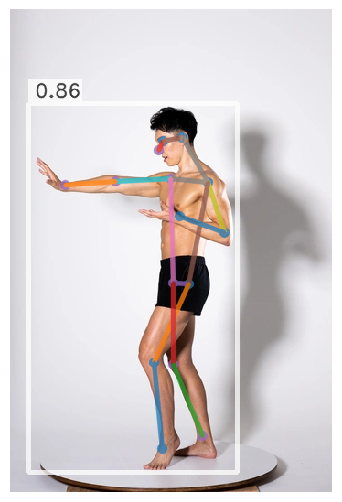

In [11]:
make_prediction("https://scdn.posemaniacs.com/muscle-plus/thumbnails/01H0MTWJ1R644B43GP1Z1K2EAY/01H0MTWJ1R644B43GP1Z1K2EAY_00003_thumb.webp", "show")

# 🩻 Display only the skeleton

If you're interested in just getting the skeleton, you can do so with the following code.

An interesting downstream project could be to take the skeleton you generate and use [DeciDiffusion](https://huggingface.co/Deci/DeciDiffusion-v1-0) for image-to-image generation and come up with some AI art. [Here's a tutorial](https://deci.ai/blog/image-to-image-translation-with-deci-diffusion-developers-guide/) for how you can do that, and a [link to the Colab](https://colab.research.google.com/drive/14TbUqWIjhoRIPcKPNT-WJbIzkhbtch9G#scrollTo=LbtjRvqZA_P1) for the same


In [13]:
# @title Code for creating skeleton images/videos
import matplotlib.pyplot as plt
import numpy as np
import cv2
from .training.utils.visualization.detection import draw_bbox
from .training.utils.visualization.pose_estimation import PoseVisualization

def process_single_image(image_prediction):
    """
    Process a single image prediction to visualize the pose estimation results on a blank background.

    Parameters:
    - image_prediction : object
        An instance containing the image and its associated pose prediction data.

    Returns:
    - np.ndarray
        An image with the pose skeleton drawn.
    """

    image = image_prediction.image
    pose_data = image_prediction.prediction

    blank_image = np.zeros_like(image)  # for a black background

    skeleton_image = PoseVisualization.draw_poses(
        image=blank_image,
        poses=pose_data.poses,
        boxes=pose_data.bboxes_xyxy,
        scores=pose_data.scores,
        is_crowd=None,
        edge_links=pose_data.edge_links,
        edge_colors=pose_data.edge_colors,
        keypoint_colors=pose_data.keypoint_colors,
        joint_thickness=2,
        box_thickness=2,
        keypoint_radius=5
    )
    return skeleton_image


def create_video_from_frames(frames, output_filename='output_video.mp4', fps=30.0):
    """
    Create an mp4 video from a list of image frames.

    Parameters:
    - frames : list of np.ndarray
        List of image frames represented as numpy arrays.
    - output_filename : str, optional
        Name of the output video file.
    - fps : float, optional
        Frames per second for the output video.

    Returns:
    - None
    """

    # Determine the width and height from the first frame
    frame_height, frame_width, layers = frames[0].shape

    # Define the codec for .mp4 format
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))

    # Write each frame to the video
    for frame in frames:
        out.write(frame)

    # Close and release everything
    out.release()
    cv2.destroyAllWindows()



In [14]:
jumpman = yolo_nas_pose.to('cuda').predict(people_posing[0], conf=.55)

image_prediction = jumpman._images_prediction_lst[0]  # Assuming you have just a single image

skeleton_image = process_single_image(image_prediction)

plt.imshow(skeleton_image)
plt.axis('off')
plt.show()

[2024-02-12 06:14:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


AttributeError: 'ImagePoseEstimationPrediction' object has no attribute '_images_prediction_lst'

# 📽️ Inference on video

In [16]:
# @title Code for downloading YouTube Videos
def extract_video_id(youtube_url):
    """
    Extract the video ID from a given YouTube URL.

    Args:
    - youtube_url (str): The full URL of the YouTube video.

    Returns:
    - str: The extracted video ID.
    """
    # Standard format: https://www.youtube.com/watch?v=VIDEO_ID
    match = re.search(r'v=([A-Za-z0-9_-]+)', youtube_url)
    if match:
        return match.group(1)

    # Shortened format: https://youtu.be/VIDEO_ID
    match = re.search(r'youtu\.be/([A-Za-z0-9_-]+)', youtube_url)
    if match:
        return match.group(1)

    # YouTube shorts format: https://www.youtube.com/shorts/VIDEO_ID
    match = re.search(r'/shorts/([A-Za-z0-9_-]+)', youtube_url)
    if match:
        return match.group(1)

    raise ValueError("Invalid YouTube URL")

def process_video(youtube_url, output_filename="download.mp4"):
    """
    Display the video, download it, and save it with the provided filename.

    Args:
    - youtube_url (str): The full URL of the YouTube video.
    - output_filename (str, optional): The name of the file to save the video as. Defaults to "download.mp4".
    """
    video_id = extract_video_id(youtube_url)

    # Display the video
    video = YouTubeVideo(video_id)
    display(video)

    # Download the video
    video_url = f'https://www.youtube.com/watch?v={video_id}'
    !python -m youtube_dl -f 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4' "$video_url" -o "$output_filename"
    print(f'Video downloaded successfully as {output_filename}')

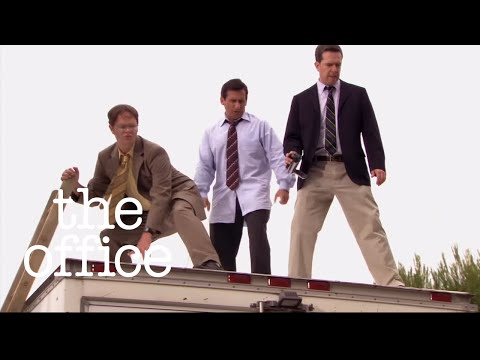

[youtube] 0Kvw2BPKjz0: Downloading webpage
[youtube] 0Kvw2BPKjz0: Downloading player 5e928255
[dashsegments] Total fragments: 3
[download] Destination: office_parkour.f137.mp4
[download] 100% of 28.14MiB in 00:01
[dashsegments] Total fragments: 1
[download] Destination: office_parkour.mp4.f140
[download] 100% of 1.48MiB in 00:00
[ffmpeg] Merging formats into "office_parkour.mp4"


In [17]:
# Example usage:
youtube_url = 'https://www.youtube.com/watch?v=0Kvw2BPKjz0'
video_name = "office_parkour.mp4"
process_video(youtube_url, video_name)

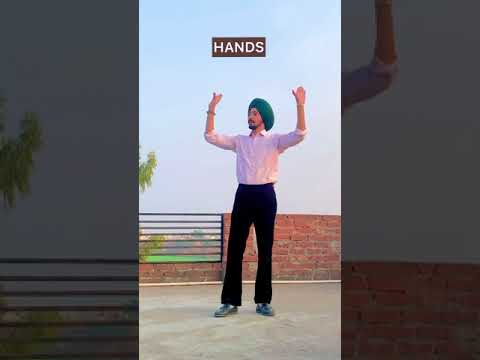

[youtube] ywu-ZtwGhDc: Downloading webpage
[youtube] ywu-ZtwGhDc: Downloading player 5e928255
[dashsegments] Total fragments: 1
[download] Destination: how-to-bhangra.f137.mp4
[download] 100% of 2.22MiB in 00:00
[dashsegments] Total fragments: 1
[download] Destination: how-to-bhangra.mp4.f140
[download] 100% of 310.75KiB in 00:00
[ffmpeg] Merging formats into "how-to-bhangra.mp4"
Deleting original file how-to-bhangra.f137.mp4 (pass -k to keep)
Deleting original file how-to-bhangra.mp4.f140 (pass -k to keep)


In [18]:
process_video("https://www.youtube.com/shorts/ywu-ZtwGhDc", 'how-to-bhangra.mp4')

# Run the following cell to create a video of the skeleton

In [19]:
result = yolo_nas_pose.to('cuda').predict("/content/how-to-bhangra.mp4", conf=.4)

processed_frames = [process_single_image(image_prediction) for image_prediction in result._images_prediction_lst]

create_video_from_frames(processed_frames, 'bhangra_skeletons.mp4', fps=30.0)

AttributeError: 'VideoPoseEstimationPrediction' object has no attribute '_images_prediction_lst'

# Inference with a pretrained model (I'll use a model that I fine-tuned on the Animal Pose dataset)

Note the weights used below are not a from a fully fine-tuned model, just weights trained for 10 epochs on Animal Pose.

In [ ]:
%%capture
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=19lnZ-ee1TMcDtKG2fTrMkaBZi1OBwrsZ

In [ ]:
animal_pose_model = models.get('yolo_nas_pose_l',
                        num_classes=20,
                        checkpoint_path="/content/animal-pose-weights-l.pth")

In [ ]:
process_video("https://youtu.be/p6CFBpe8zws", 'horsies.mp4')

In [ ]:
animal_pose_model.predict('horsies.mp4', conf=0.60).save("horsies-detections.mp4")

In [ ]:
animal_pose_model.predict("https://previews.123rf.com/images/ksuksa/ksuksa1911/ksuksa191100411/134285899-mixed-breed-dog-posing-outdoors-in-winter.jpg", conf=0.60).show()

# Next Steps

Check out the fine-tuning tutorial [here](https://bit.ly/yn-pose-fine-tuning).